# Multiple Output Models -  Keras Functional API

In [1]:
import pandas as pd 
import tensorflow as tf 
import numpy as np 

# URL of the white wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

data_red = pd.read_csv(URL, sep = ';')
data_red['is_red'] = 0
data_red = data_red.drop_duplicates(keep = 'first')

# URL of the red wine dataset
URL2 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data_white = pd.read_csv(URL2, sep = ';')
data_white['is_red'] = 1
data_white = data_white.drop_duplicates(keep = 'first')

data = pd.concat([data_red, data_white], ignore_index = True)
data.head(3)

2025-01-06 20:50:15.876223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0


In [2]:
# shuffle data 
data = data.iloc[np.random.permutation(len(data))]

# Checking imbalanced data
data.quality.value_counts().reset_index()

,quality,count
0,6,2323
1,5,1752
2,7,856
3,4,206
4,8,148
5,3,30
6,9,5


In [3]:
# So, we get data with wine quality greater than 4 and less than 8
data = data[(data['quality'] > 4) & (data['quality'] < 8 )]

data = data.reset_index(drop = True)

In [4]:
from sklearn.model_selection import train_test_split

# Spliting into train test set
train, test = train_test_split(data, test_size = 0.2, random_state = 42)
                               
# Spliting into train validation set
train, val = train_test_split(train, test_size = 0.2, random_state = 42)

In [5]:
from sklearn.preprocessing import StandardScaler

def separate_columns(data):
    '''
    The features and labels are currently in the same dataframe. 
    We want to store the label columns `is_red` and `quality` separately from the feature columns.
    '''
    red_wine = data.pop('is_red')
    red_wine = np.array(red_wine)
    quality = data.pop('quality')
    quality = np.array(quality)
    
    return (red_wine, quality)

y_train = separate_columns(train)
y_val = separate_columns(val)
y_test = separate_columns(test)

#-----------------------------------
scaler = StandardScaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)


In [6]:
# Defining the model using functional API.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input


input = Input(shape = (train.shape[1],))
x = Dense(units = 128, activation = 'relu')(input)
x = Dense(units = 128, activation = 'relu')(x)

# Regression
wine_quality = Dense(units = 1, name = 'wine_quality')(x)

# Classification - using sigmoid
branch_wine_type = Dense(units = 128, activation = 'relu', name = 'branch_wine_type')(x)
wine_type = Dense(units = 1, name = 'wine_type', activation = 'sigmoid')(branch_wine_type)
model = Model(inputs = input, outputs = [wine_type, wine_quality])

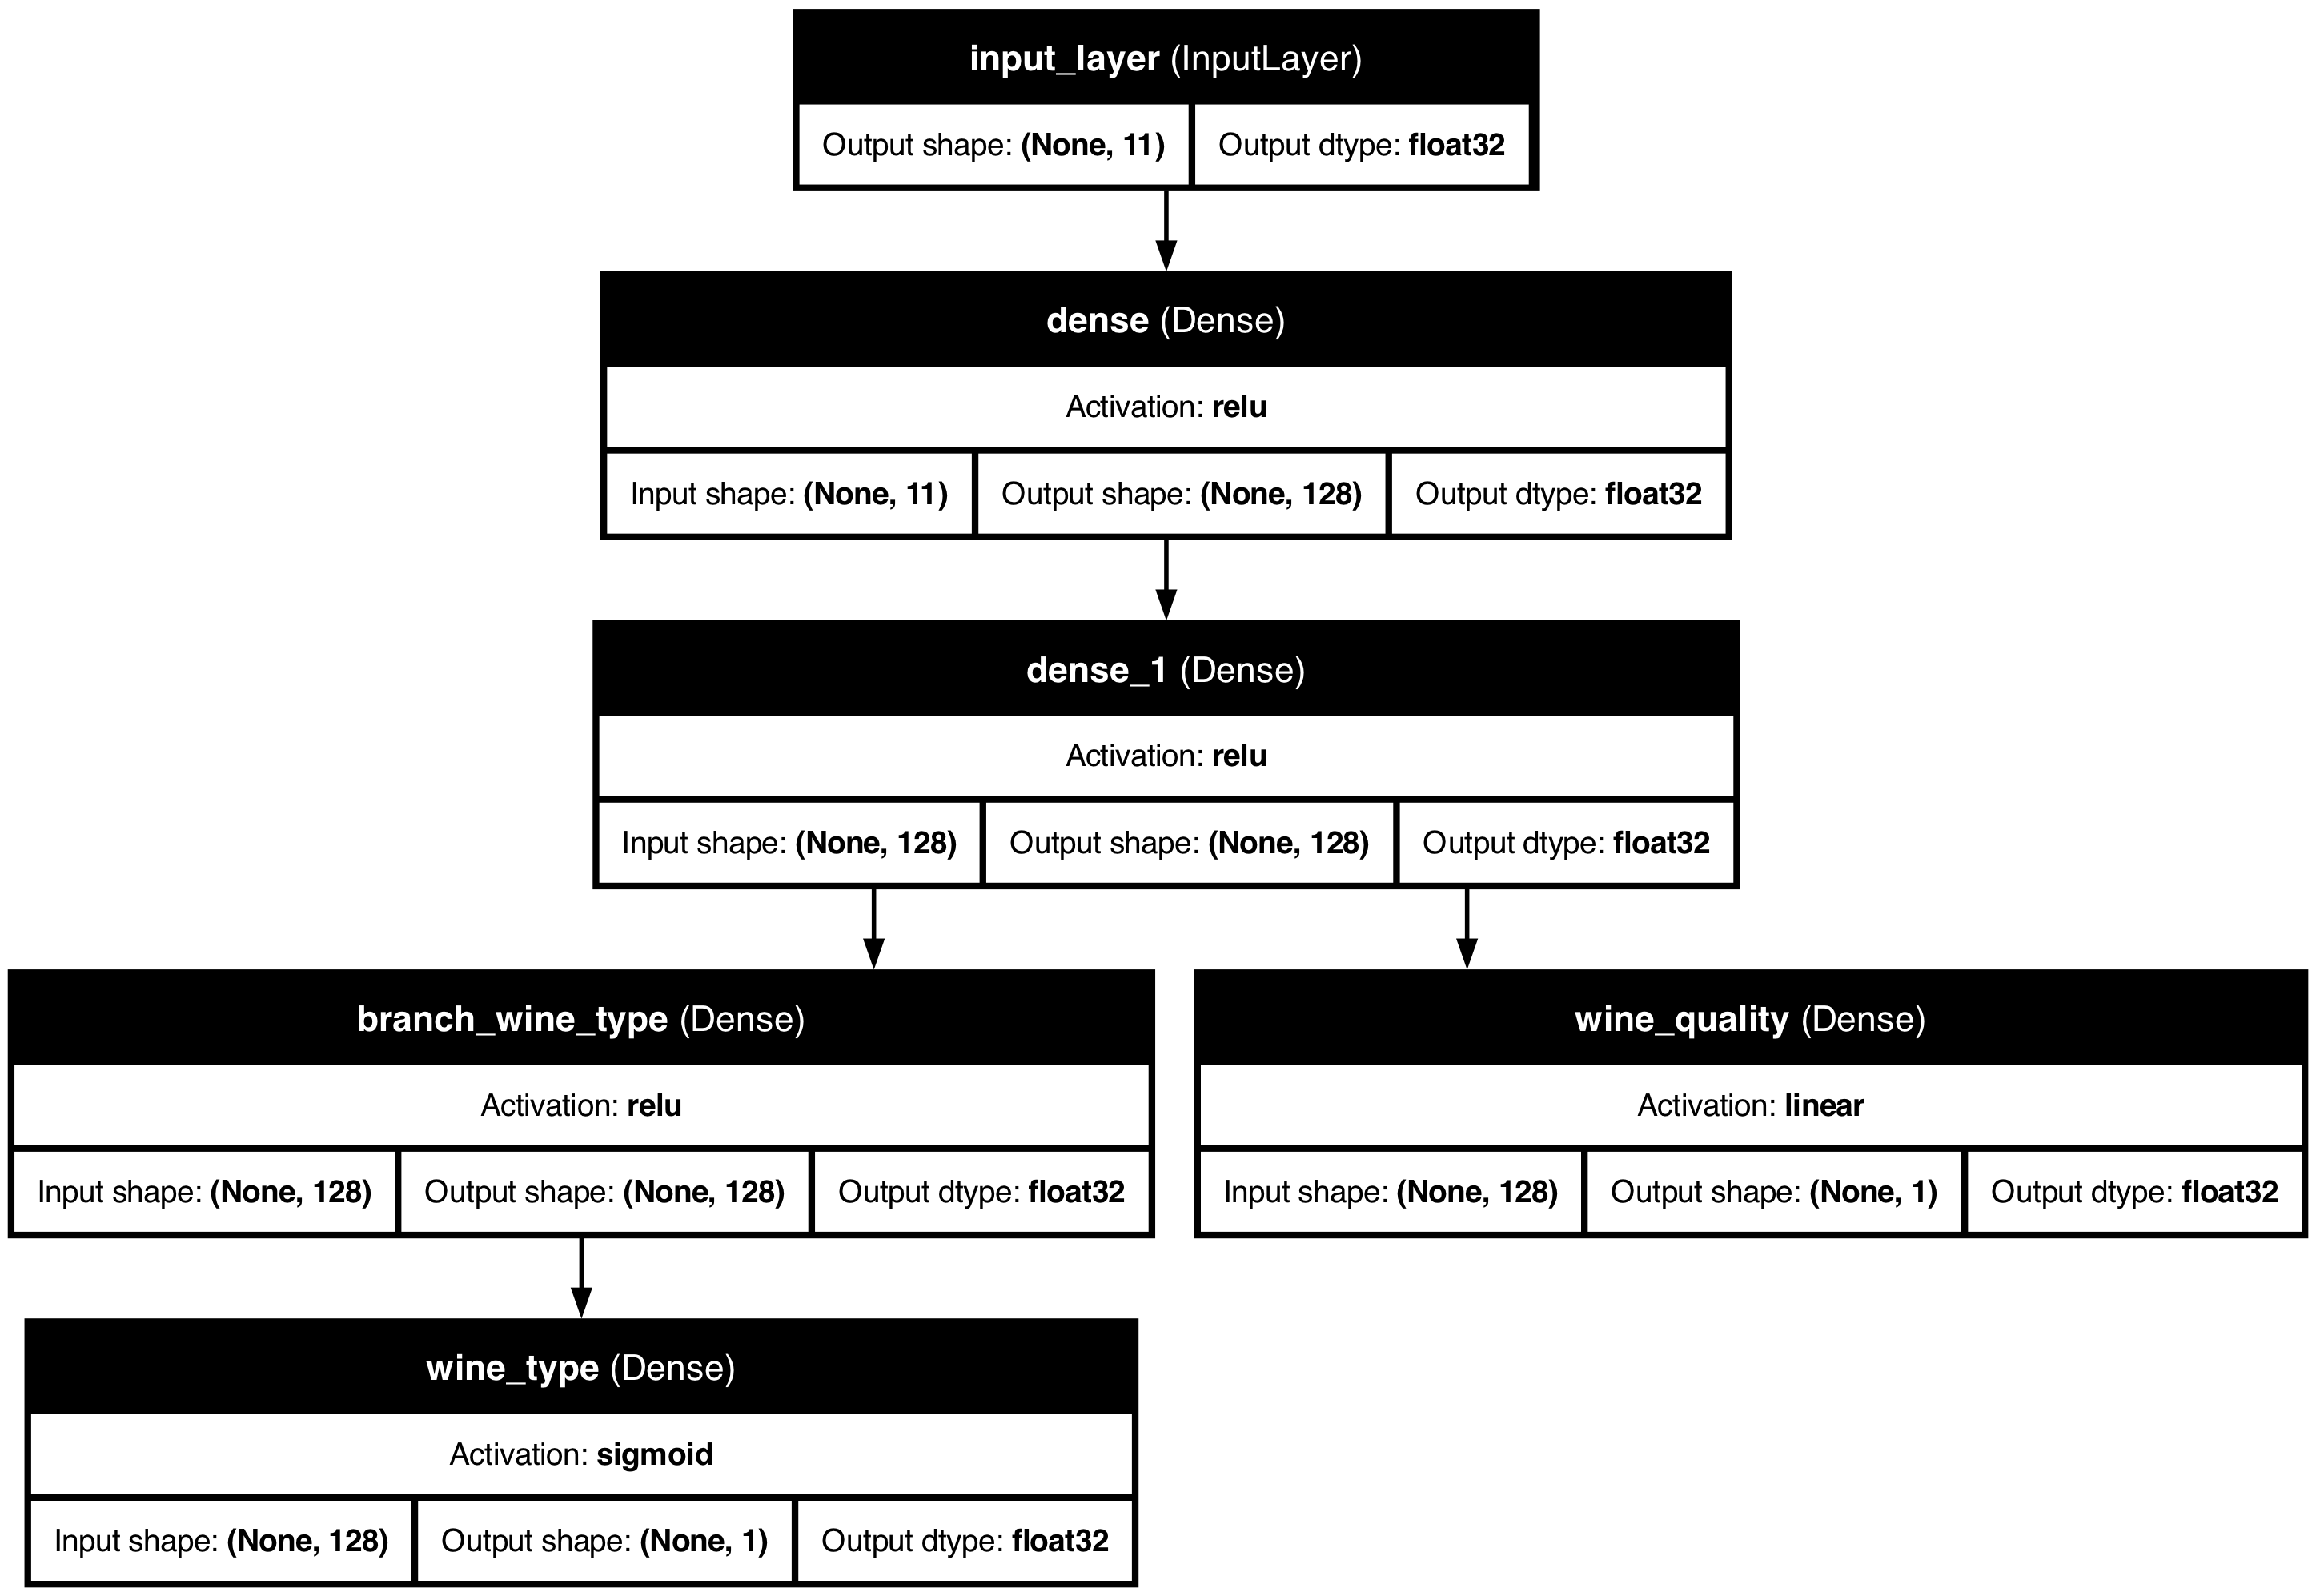

In [7]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True, show_layer_activations = True)

In [8]:
# Compiling the model
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError

model.compile(optimizer = RMSprop(learning_rate = 0.001),
              loss = {'wine_quality': MeanSquaredError(),'wine_type': BinaryCrossentropy()},
              metrics = {'wine_quality': RootMeanSquaredError(), 'wine_type': 'accuracy'})

history = model.fit(train,
                    y_train,
                    epochs = 100,
                    validation_data = (val, y_val),
                    verbose = 1)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 10.0447 - wine_quality_loss: 9.7702 - wine_quality_root_mean_squared_error: 2.9796 - wine_type_accuracy: 0.9113 - wine_type_loss: 0.2742 - val_loss: 1.2073 - val_wine_quality_loss: 1.1587 - val_wine_quality_root_mean_squared_error: 1.0747 - val_wine_type_accuracy: 0.9899 - val_wine_type_loss: 0.0522
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1975 - wine_quality_loss: 1.1660 - wine_quality_root_mean_squared_error: 1.0793 - wine_type_accuracy: 0.9940 - wine_type_loss: 0.0315 - val_loss: 0.7921 - val_wine_quality_loss: 0.7275 - val_wine_quality_root_mean_squared_error: 0.8524 - val_wine_type_accuracy: 0.9810 - val_wine_type_loss: 0.0651
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7513 - wine_quality_loss: 0.7181 - wine_quality_root_mean_squared_error: 0.8467 - wine_type_accuracy: 0.9937 - wine_type_loss: 0.0332 - val_loss: 0.6002 - val_wine_quality_loss: 0.5612 - val_wine_quality_root_mean_squar

In [9]:
############ TESTING #################
predictions = model.predict(test)
np.array(predictions).shape # 2 dimensions (one for each target)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(2, 987, 1)

In [10]:
wine_type_pred = predictions[0]
wine_quality_pred = predictions[1]

# print(wine_type_pred[:10])
# print(wine_type_pred[:10])

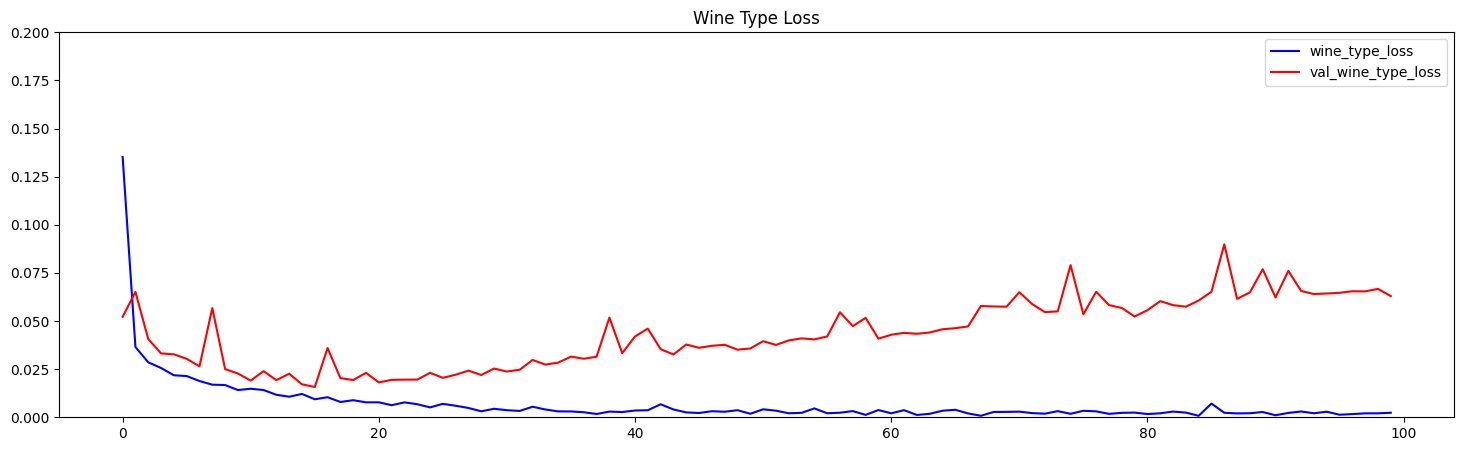

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(metric_name, title, ylim=5):
    plt.figure(figsize = (18, 5))
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name],color = 'blue',label = metric_name)
    plt.plot(history.history['val_' + metric_name],color = 'red',label = 'val_' + metric_name)
    plt.legend()

plot_metrics('wine_type_loss', 'Wine Type Loss', ylim = 0.2)

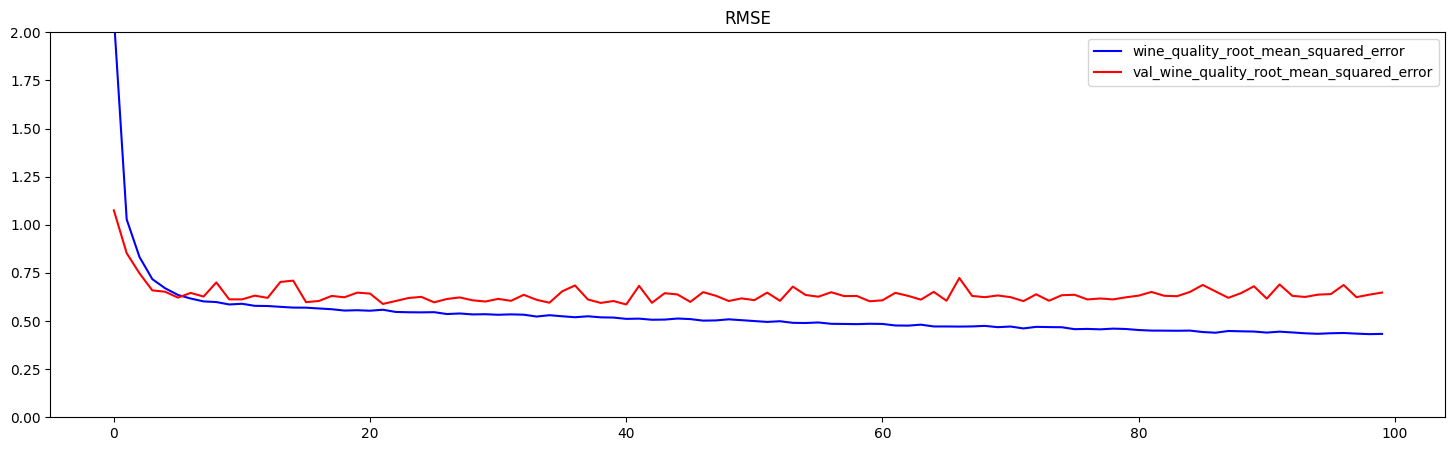

In [12]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim = 2)